# Passo 1 - Setup do projeto

In [1]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

print(f'Matplot version: {matplotlib.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'sklearn version: {sklearn.__version__}')

DATA_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
DATA_URL  = DATA_ROOT + 'crx.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'crx.csv'

CRX_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_FILE = 'finalized_model.sav'

RANDOM_STATE = 42

Matplot version: 3.3.4
Numpy version: 1.20.1
Pandas version: 1.2.2
sklearn version: 0.24.1


# Passo 2 - Carregando dados

In [2]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [3]:
download_data(DATA_URL, DATA_PATH, DATA_FILE)

In [4]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['Male','Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed',
                                                       'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved'])

In [5]:
crx_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3 - Análise Exploratória de dados

In [6]:
crx_data.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Transformando o valor para binário

In [7]:
for index in crx_data.index:
    if crx_data.loc[index, 'Approved'] == '+':
        crx_data.loc[index, 'Approved'] = 1
    else:
        crx_data.loc[index, 'Approved'] = 0


In [8]:
crx_data['Approved'] = crx_data['Approved'].astype('int')
crx_data.head()


,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,1


In [9]:
crx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int32  
dtypes: float64(2), int32(1), int64(2), object(11)
memory usage: 83.7+ KB


In [10]:
crx_data.describe()

,Debt,YearsEmployed,CreditScore,Income,Approved
count,690.000000,690.000000,690.00000,690.000000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507,0.444928
std,4.978163,3.346513,4.86294,5210.102598,0.497318
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.165000,0.00000,0.000000,0.000000
50%,2.750000,1.000000,0.00000,5.000000,0.000000
75%,7.207500,2.625000,3.00000,395.500000,1.000000
max,28.000000,28.500000,67.00000,100000.000000,1.000000


In [11]:
crx_data['Approved'].value_counts()

0    383
1    307
Name: Approved, dtype: int64

In [12]:
x = crx_data[['Debt', 'YearsEmployed', 'CreditScore', 'Income']]
y = crx_data['Approved']

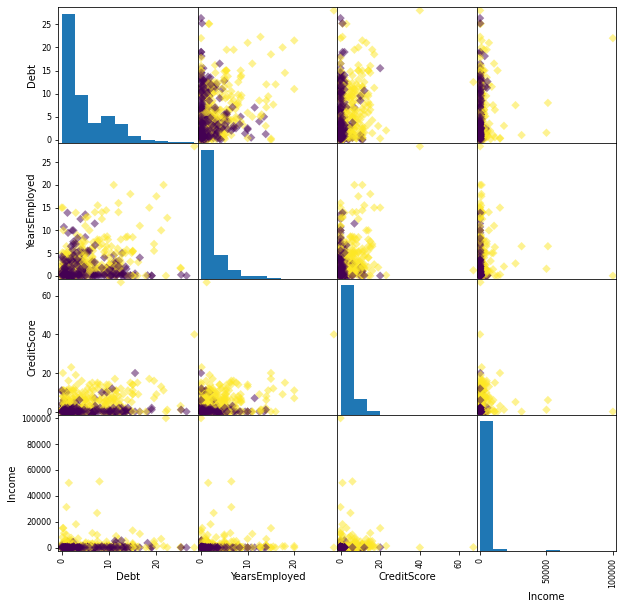

In [13]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(x, c=cores,figsize=[10,10], marker='D')

# Passo 4 - Treinamento do Modelo

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=RANDOM_STATE)

In [26]:
def build_classifiers():

    classifiers = []

    classifiers.append(
        ('knn',                              # nome do classificador
        KNeighborsClassifier(),             # instacia do classificador
        {'n_neighbors': range(1, 33, 2)})    # Hyperparamentro
    )

    classifiers.append(
        ('LR',                             
        (max_iter=1000), 
        {'penalty': ['l2'], 'C':[100,10,1,0.1,0.01]})    
    )

    classifiers.append(
        ('svm',                              
        SVC(), 
        {'kernel': ['rbf'], 'C':[2**(-5), 1, 2**5, 2**10],
        'gamma': [2**(-15), 2**(-10), 2**(-5), 1, 2**5]})   
    )

    classifiers.append(
        ('dt',                              
        DecisionTreeClassifier(), 
        {'max_depth':[2, 4, 6, 8, 10, 12]})   
    )

    classifiers.append(
        ('rf',                              
        RandomForestClassifier(), 
        {'n_estimators':[10, 50, 100,]})   
    )

    classifiers.append(
        ('gpc',                              
        GaussianProcessClassifier(), 
        {'kernel':[1.0 * RBF(1.0)]})   
    )

    return classifiers

# Passo 4.1 - Verificação métricas de treino 

In [31]:
classifiers = build_classifiers()
results = []
names = []
for name, model, parameters in classifiers:
    print(f'>> classifier name {name}')
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, x_train, y_train, cv=kf, scoring='accuracy')
    print(f'Mean: {cv.mean()}, STD: {cv.std()}')
    results.append(cv)
    names.append(name)

>> classifier name knn
Mean: 0.7081632653061225, STD: 0.06484427597202584
>> classifier name LR
Mean: 0.7576955782312925, STD: 0.06298473750238426
>> classifier name svm
Mean: 0.7309948979591836, STD: 0.056600995855619375
>> classifier name dt
Mean: 0.7244897959183674, STD: 0.05492433762569777
>> classifier name rf
Mean: 0.745280612244898, STD: 0.07227202098007245
>> classifier name gpc
Mean: 0.6855017006802722, STD: 0.07997901034936877


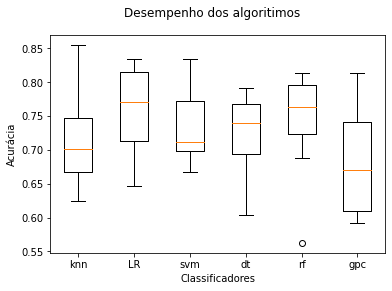

In [32]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritimos')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')
plt.show()

# Passo 4.2 - Verificação métricas de teste 

In [33]:
classifiers = build_classifiers()
results = []
names = []
for name, model, parameters in classifiers:
    print(f'>> classifier name {name}')
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, x_test, y_test, cv=kf, scoring='accuracy')
    print(f'Mean: {cv.mean()}, STD: {cv.std()}')
    results.append(cv)
    names.append(name)

>> classifier name knn
Mean: 0.7285714285714285, STD: 0.06535269739413471
>> classifier name LR
Mean: 0.7726190476190478, STD: 0.1224432396613856
>> classifier name svm
Mean: 0.6752380952380952, STD: 0.08214941312692078
>> classifier name dt
Mean: 0.7, STD: 0.0943350039514577
>> classifier name rf
Mean: 0.71, STD: 0.12689292359685359
>> classifier name gpc
Mean: 0.6469047619047619, STD: 0.12284445301757912


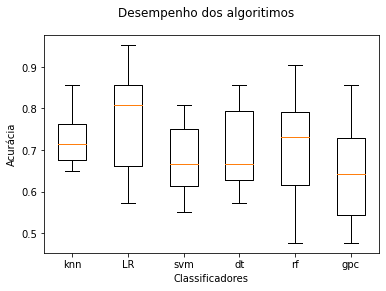

In [34]:
fig, ax = plt.subplots()
fig.suptitle('Desempenho dos algoritimos')
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Acurácia')
ax.set_xlabel('Classificadores')
plt.show()

### O método de classificação escolhida será o "LogisticRegression" pois ele apresentou maior acurácia tanto no treino quanto no teste.